<a href="https://colab.research.google.com/github/douglascdev/fake_stock_price/blob/main/fake_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install quantumrandom

In [ ]:
import random
from datetime import datetime, timedelta

import numpy as np
import quantumrandom

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import concurrent.futures
import pandas as pd


def get_true_random_data(array_length: int = 1024):
    """
    Returns infinite ints obtained from quantumrandom calling their API every array_length number of ints
    :param array_length:
    :return:
    """
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(quantumrandom.get_data, array_length=array_length) for _ in range(10)]
        while True:
            res = futures.pop(0).result()
            if not futures:
                futures += [executor.submit(quantumrandom.get_data, array_length=array_length) for _ in range(5)]
            for i in res:
                yield i


random_data_iterator = iter(get_true_random_data())


def get_true_random_normalized(n: int):
    """
    get_truly_random_data returning values between 0 to 1
    :param n:
    :return:
    """
    for _, seed in zip(range(n), random_data_iterator):
        random.seed(seed)
        yield random.random()


def true_random_choices(population, weights):
    while True:
        random.seed(next(random_data_iterator))
        yield random.choices(population, weights, k=1).pop()


def generate_weighted_random_variation():
    # weights = [10000, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
    #            0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
    #            0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    weights = [10000]
    weights += [0.01] * 5
    weights += [0.05] * 5
    weights += [0.001] * 50

    random_population = sorted(get_true_random_normalized(len(weights)))
    return next(iter(true_random_choices(random_population, weights)))


def gen_positive() -> bool:
    """
    If the random variation in price will be positive or negative.
    Positive has a slightly higher chance to emulate the general tendendy
    of going up over time
    """
    return next(iter(true_random_choices([True, False], [1.001, 1])))


def generate_random_data(data_size: int, initial_value: int = 40):
    values = [initial_value]
    last_value = initial_value
    for _ in range(data_size):
        percent_variation = generate_weighted_random_variation()
        variation = percent_variation if gen_positive() else -percent_variation
        last_value = round(last_value + (last_value * variation), 2)
        if last_value < 0:
            last_value = 0
        values.append(last_value)
    return values

In [ ]:
data = generate_random_data(data_size=10000, initial_value=10)
dates = [datetime(1990, 9, 28, 0, 0) + timedelta(days=i) for i in range(len(data))]

In [ ]:
df = pd.DataFrame({"Date": dates, "Close": data})
df.head()


,Date,Close
0,1990-09-28,10.00
1,1990-09-29,10.12
2,1990-09-30,10.69
3,1990-10-01,10.87
4,1990-10-02,11.08


In [ ]:
df.to_csv("data.csv")

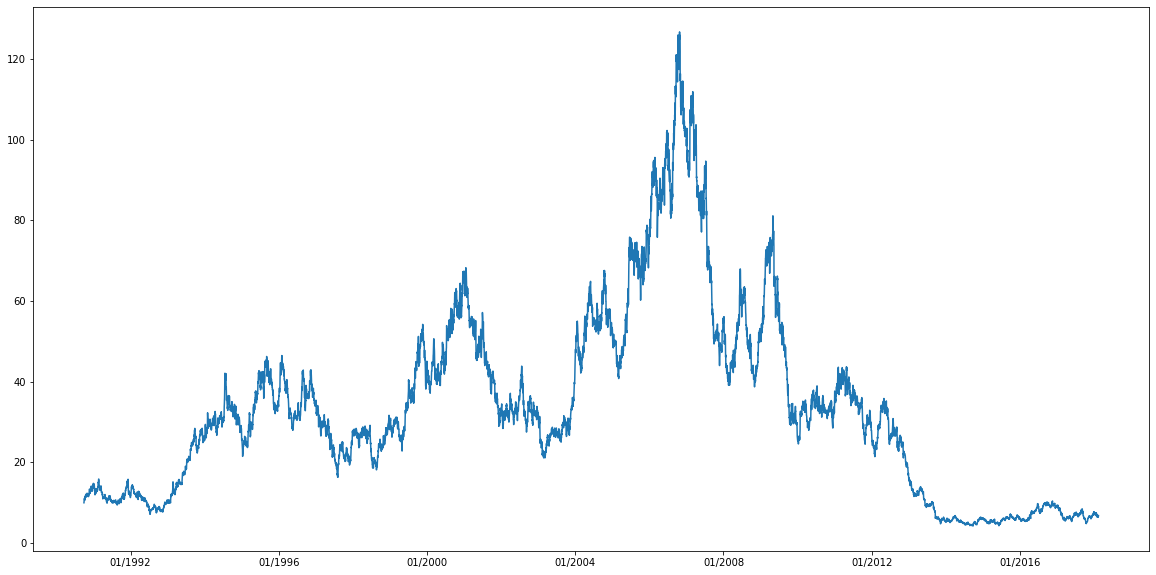

In [ ]:
y = np.array(data)
x = np.array(dates)

plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(x, y)

xformatter = mdates.DateFormatter('%m/%Y')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

plt.show()
